# Setup


In [2]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
from enum import Enum
import csv
import matplotlib.pyplot as plt
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

seed_constant = 507
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

2023-12-03 12:27:33.002065: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Grab, label, and normalize data

In [10]:
data_path = '../data/steps_in_3s/'



class cat:
    front = 0
    heel = 1
    noise = 2
cat_count = [0,0,0]
test_input, train_input = [], []
test_labels, train_labels = [], []
input_count = 0
max_input = -1

width = 27
height = 3


for file_name in os.listdir(data_path):
    f_path = os.path.join(data_path, file_name)
    if os.path.isfile(f_path):
        f = open(f_path,'r')
        cat_str = f_path.split("ST")[1][0]
        cat_type = cat.noise
        speed = f_path.split("P")[1][0]
        if(cat_str == 'f'):
            cat_type = cat.front
        elif(cat_str == 'h'):
            cat_type = cat.heel
        
        rows = f.readlines()
        for r in rows:
           #print(r)
            triplet = np.abs(np.reshape(np.array(r.split(',')).astype(np.float32), (height,width,1)))
            input_count += 1
            cat_count[cat_type] += 1

            # check for new max
            temp_max = np.max(triplet)
            if(temp_max > max_input):
                max_input = temp_max

            if speed == '4':
                test_input.append(triplet)
                test_labels.append(cat_type)
            else:
                train_input.append(triplet)
                train_labels.append(cat_type)
        f.close()

#normalize data
train_input = train_input / max_input
test_input = test_input / max_input

print("total input: ", input_count)
print("total test data: ", len(test_labels))
print("total training data: ", len(train_labels))
print("input by category (f,h,n): ", cat_count)

print(np.shape(np.array(train_labels)))

total input:  1825
total test data:  182
total training data:  1643
input by category (f,h,n):  [897, 872, 56]
(1643,)


# CNN
look up more info about how this is used

In [4]:
def create_model():
 
    model = Sequential()
 
    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = 'relu', input_shape = (height, width, 1)))
    model.add(Conv2D(filters = 64, kernel_size = (2, 4), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((1,2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(len(cat_count), activation = 'softmax'))
 
    # Printing the models summary
    model.summary()
 
    return model
 
 
# Calling the create_model method
model = create_model()
 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 27, 64)         640       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 24, 64)         32832     
                                                                 
 batch_normalization (BatchN  (None, 2, 24, 64)        256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 12, 64)        0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

In [11]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start Training
model_training_history = model.fit(x = np.array(train_input), y = np.array(train_labels), epochs = 50, batch_size = 2, shuffle = True, validation_split = 0.3, callbacks = [early_stopping_callback])


Epoch 1/50
575/575 [==============================] - 3s 3ms/step - loss: 0.5369 - accuracy: 0.7278 - val_loss: 2.6562 - val_accuracy: 0.5862
Epoch 2/50
575/575 [==============================] - 2s 3ms/step - loss: 0.5271 - accuracy: 0.7330 - val_loss: 0.8452 - val_accuracy: 0.5152
Epoch 3/50
575/575 [==============================] - 2s 3ms/step - loss: 0.5040 - accuracy: 0.7435 - val_loss: 2.3793 - val_accuracy: 0.4381
Epoch 4/50
575/575 [==============================] - 2s 3ms/step - loss: 0.5098 - accuracy: 0.7426 - val_loss: 0.9249 - val_accuracy: 0.5984
Epoch 5/50
575/575 [==============================] - 2s 3ms/step - loss: 0.5151 - accuracy: 0.7348 - val_loss: 1.8883 - val_accuracy: 0.5943
Epoch 6/50
575/575 [==============================] - 2s 3ms/step - loss: 0.4939 - accuracy: 0.7461 - val_loss: 0.4963 - val_accuracy: 0.6957
Epoch 7/50
575/575 [==============================] - 2s 3ms/step - loss: 0.5302 - accuracy: 0.7139 - val_loss: 0.7491 - val_accuracy: 0.6126
Epoch 

In [12]:
model_evaluation_history = model.evaluate(np.array(test_input), np.array(test_labels))

# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Saving your Model
model.save(model_name)

6/6 [==============================] - 0s 3ms/step - loss: 0.5873 - accuracy: 0.7143


In [13]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]
 
  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
   
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
   
  # Adding title to the plot
  plt.title(str(plot_name))
 
  # Adding legend to the plot
  plt.legend()

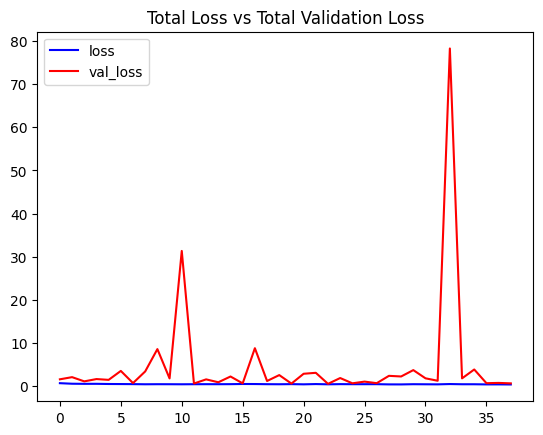

In [8]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

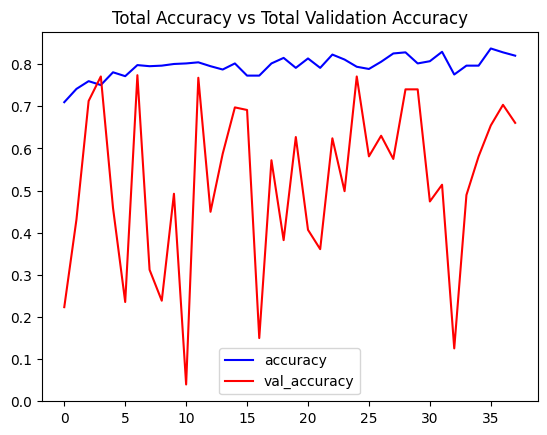

In [9]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')